In [16]:
from datetime import timedelta
import s3fs
url = "s3://noaa-ghcn-pds/csv/by_station/" + 'USC00087205' + ".csv"
df = pd.read_csv(url, storage_options={"anon": True}, dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},parse_dates=['DATE']).set_index('DATE')
df['left'] = df.index - timedelta(days=0.5)
df['right'] = df.index + timedelta(days=0.5)
plantcity = df[df['ELEMENT']=='TMIN']

C:\Users\pranj\AppData\Local\Temp\ipykernel_32580\3466795509.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options={"anon": True}, dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},parse_dates=['DATE']).set_index('DATE')


In [17]:
plantcity = plantcity[plantcity.index.year.isin(range(1991,2020))]

In [25]:
freeze =  plantcity[(plantcity['DATA_VALUE']<=28)&(plantcity.index.month.isin([1,10,11,12]))]
frost = plantcity[(plantcity['DATA_VALUE']<=32 )&(plantcity.index.month.isin([1,10,11,12]))]
freeze['count']=1
frost['count']=1

C:\Users\pranj\AppData\Local\Temp\ipykernel_32580\2377691573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freeze['count']=1
C:\Users\pranj\AppData\Local\Temp\ipykernel_32580\2377691573.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frost['count']=1


In [27]:
frzdays = freeze['count'].groupby([freeze.index.year,freeze.index.month]).sum().mean()

In [30]:
frstdays = frost['count'].groupby([frost.index.year,frost.index.month]).sum().mean()

In [35]:
print('The mean risk of frost and freeze is',frstdays,'&',frzdays,'days respectively')

The mean risk of frost and freeze is 3.433333333333333 & 3.433333333333333 days respectively


In [36]:
enso = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/censo.data',
                    delim_whitespace=True,header=None,skiprows=1,skipfooter=2, engine='python')

nao = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/nao.data',
                    delim_whitespace=True,header=None,skiprows=1,skipfooter=3, engine='python')


In [37]:
nao_new=pd.DataFrame()
enso_new=pd.DataFrame()

enso_new['Date']=pd.date_range(start=pd.datetime(1948,1,1),
                                end=pd.datetime(2022,12,1),freq="MS")
nao_new['Date'] = pd.date_range(start=pd.datetime(1948,1,1),
                                end=pd.datetime(2022,12,1),freq="MS")

enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')

enso_new['ENSO']=enso.loc[:,1:].stack().values
nao_new['NAO']=nao.loc[:,1:].stack().values


C:\Users\pranj\AppData\Local\Temp\ipykernel_32580\3772462537.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  enso_new['Date']=pd.date_range(start=pd.datetime(1948,1,1),
C:\Users\pranj\AppData\Local\Temp\ipykernel_32580\3772462537.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end=pd.datetime(2022,12,1),freq="MS")
C:\Users\pranj\AppData\Local\Temp\ipykernel_32580\3772462537.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  nao_new['Date'] = pd.date_range(start=pd.datetime(1948,1,1),
C:\Users\pranj\AppData\Local\Temp\ipykernel_32580\3772462537.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime mod

In [40]:
import numpy as np
clim = pd.merge(enso_new,nao_new, 
                    left_index=True, right_index=True)
clim['ENSO'][clim['ENSO'] <= -9.9] = np.nan
clim['NAO'][clim['NAO'] <= -99.9] = np.nan


In [50]:
ensoind = []
naoind = []
s=-1
for j in clim.index:
    s=s+1
    for i in freeze.index:
        if(j.year==i.year & j.month==i.month):
            print(j.year)
            # ensoind.append(clim['ENSO'][s])
            # naoind.append(clim['NAO'][s])

In [51]:
freeze.index= pd.MultiIndex.from_arrays([freeze.index.year, 
                                            freeze.index.month], 
                                            names=['yr','mo'])
clim.index= pd.MultiIndex.from_arrays([clim.index.year, 
                                            clim.index.month], 
                                            names=['yr','mo'])

In [54]:
freezeclim = freeze.join(clim)

In [56]:
freezeve1 = freezeclim[freezeclim['ENSO']<-0.5]
freezeve2 = freezeclim[(freezeclim['ENSO']>=-0.5)&(freezeclim['ENSO']<=0.5)]
freezeve3 = freezeclim[freezeclim['ENSO']>0.5]

In [65]:
freezevents = dict(
    {'ENSO<-0.5':freezeve1['count'].sum(),
    'ENSO-[-0.5,0.5]':freezeve2['count'].sum(),
    'ENSO>0.5':freezeve3['count'].sum()
    })
print('Freeze events with ENSO variation-',freezevents)

Freeze events with ENSO variation- {'ENSO<-0.5': 93, 'ENSO-[-0.5,0.5]': 53, 'ENSO>0.5': 60}


In [61]:
freezeve4 = freezeclim[freezeclim['NAO']<-0.5]
freezeve5 = freezeclim[(freezeclim['NAO']>=-0.5)&(freezeclim['NAO']<=0.5)]
freezeve6 = freezeclim[freezeclim['NAO']>0.5]

In [64]:
freezevents2 = dict(
    {'NAO<-0.5':freezeve4['count'].sum(),
    'NAO-[-0.5,0.5]':freezeve5['count'].sum(),
    'NAO>0.5':freezeve6['count'].sum()
    })
print('Freeze events with NAO variation-',freezevents2)

Freeze events with NAO variation- {'NAO<-0.5': 83, 'NAO-[-0.5,0.5]': 78, 'NAO>0.5': 45}


<AxesSubplot: xlabel='yr,mo'>

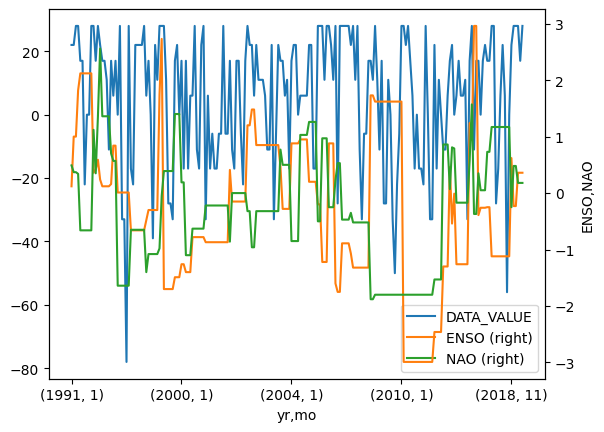

In [73]:
import matplotlib.pyplot as plt
freezeclim[['DATA_VALUE','ENSO','NAO']].plot(secondary_y=['ENSO','NAO'],ylabel='ENSO,NAO')

In [80]:
from scipy.stats import pearsonr
print('1) Relation with ENSO-',
    pearsonr(freezeclim['DATA_VALUE'],freezeclim['ENSO']),
    '2) Relation with NAO-',
    pearsonr(freezeclim['DATA_VALUE'],freezeclim['NAO']))


1) Relation with ENSO- PearsonRResult(statistic=0.12023619223637769, pvalue=0.08516670445436665) 2) Relation with NAO- PearsonRResult(statistic=0.17150358261474058, pvalue=0.013707004987124504)


### From the pearson's R^2 values it is evident that there is no direct strong relation between Freeze events and climate indices

In [85]:
freezeclim = freezeclim.reset_index('mo')

In [88]:
freezecounts = freezeclim['count'].groupby([freezeclim.mo,freezeclim.index]).sum()
ens = freezeclim['ENSO'].groupby([freezeclim.mo,freezeclim.index]).mean()
na = freezeclim['NAO'].groupby([freezeclim.mo,freezeclim.index]).mean()

In [92]:
#Relationship of freeze counts with climate indices
print('1) relationship with ENSO-',pearsonr(freezecounts,ens),
'2) relationship with NAO-',pearsonr(freezecounts,na))


1) relationship with ENSO- PearsonRResult(statistic=-0.27229201600472114, pvalue=0.03531351416118369) 2) relationship with NAO- PearsonRResult(statistic=-0.3802183891123361, pvalue=0.002729849008118207)


### The monthly freezecounts show weak negative relationship with climate indices